# IRL for PdM
- V.1.0 04-Aug-2024: First version
- V.2.0 07-Aug-2024: New milling env.: Drop Time observation. All force and vibration axes (x, y, z) 

In [2]:
import warnings
from tqdm import tqdm # Progress bar
from datetime import datetime
warnings.filterwarnings('ignore')

# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# RL libraries
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO, A2C
from stable_baselines3.ppo import MlpPolicy
from torch.utils.tensorboard import SummaryWriter

# CH-AI Imitation libraries
from imitation.util.util import make_vec_env
from imitation.data import rollout, serialize
from imitation.data.wrappers import RolloutInfoWrapper
# Custom libraries
from MT_environment import MillingTool_Env
from utilities import downsample, tool_wear_data

In [16]:
DATA_FILE = 'PHM_C01.csv'
WEAR_THRESHOLD = 0.12
SAMPLING_RATE = 1
ADD_NOISE = 0

EPISODES = 4_000
BATCH_SIZE = 16
SAMPLE_DEMONSTRATIONS = 100
EVALUATION_ROUNDS = 20
TENSOR_BOARD = True

PRETRAINED_MODEL = True # If True load model. If False save as model_file 
SAVED_DEMONSTRATIONS = True # If True load saved demonstrations. If False save them
MODEL_FILE = 'Expert_Model_PPO'
PATH = 'D:/ResearchLab/IRL/IRL_for_PdM/'
LOG_PATH = 'D:/ResearchLab/IRL/IRL_for_PdM/tensorboard/'
# LOG_PATH = f'{PATH}/tensorboard/{now.strftime("%d-%b-%Y_%H_%M")}/'

writer = SummaryWriter(LOG_PATH) if TENSOR_BOARD else None 
print(f'Tensorboard logging to {LOG_PATH}')

Tensorboard logging to D:/ResearchLab/IRL/IRL_for_PdM/tensorboard/


- Down-sampling. Input data records: 1000. Sampling rate: 1. Expected rows 1000.    Down-sampled to 1000 rows.


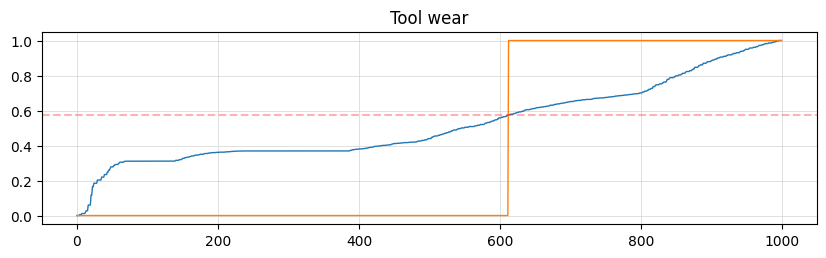

Tool failure RUL threshold at time 950 is 0.050


In [4]:
tool_wear, action_code, WEAR_THRESHOLD_NORMALIZED, df_train = tool_wear_data(
    data_file=DATA_FILE, wear_threshold = WEAR_THRESHOLD,
    normalize=True, add_noise=ADD_NOISE, sampling_rate = SAMPLING_RATE)

records = len(df_train.index)
MILLING_OPERATIONS_MAX = records

rul_threshold_record = int(0.95 * records)
rul_threshold = df_train.loc[df_train.index[rul_threshold_record], 'RUL']
print(f'Tool failure RUL threshold at time {rul_threshold_record} is {rul_threshold:3.3f}')

## 1. Predictive maintenance environment

In [5]:
from stable_baselines3.common.env_checker import check_env

gym.register(
    id = 'custom/MillingToolEnv-v0',
    entry_point = MillingTool_Env,
    max_episode_steps = MILLING_OPERATIONS_MAX,
)

mt_env = gym.make('custom/MillingToolEnv-v0', records=records, rul_threshold=rul_threshold)
# Check env. formation 
check_env(mt_env)


 -- Milling tool environment initiatlized. Potential records 1000. RUL threshold 0.050


In [6]:
mt_env.tool_wear_data(df_train)


 - Milling tool environment: Tool wear data updated: 1000


## 2. The "Human" Expert

In [7]:
if TENSOR_BOARD:
    expert_ppo = PPO('MlpPolicy', env=mt_env, tensorboard_log=LOG_PATH)
else:
    expert_ppo = PPO('MlpPolicy', env=mt_env)

if not PRETRAINED_MODEL:
    print(f'- Training a *NEW* Expert model...')
    expert_ppo.learn(EPISODES)
    print(f'- Saving Expert model in {MODEL_FILE}')
    expert_ppo.save(MODEL_FILE)
else:
    print(f'- Loading pre-tranined Expert model from {MODEL_FILE}')
    expert_ppo = PPO.load(MODEL_FILE)

- Loading pre-tranined Expert model from Expert_Model_PPO


In [8]:
# if TENSOR_BOARD:
#     expert_a2c = A2C('MlpPolicy', env=mt_env, tensorboard_log=LOG_PATH)
# else:
#     expert_a2c = A2C('MlpPolicy', env=mt_env)

# expert_a2c.learn(EPISODES)

In [9]:
reward_ppo, _ = evaluate_policy(expert_ppo, mt_env, 5)
print(f'PPO Expert reward: {reward_ppo:4.2f}')

# reward_a2c, _ = evaluate_policy(expert_a2c, mt_env, 20)
# print(f'A2C Expert reward: {reward_a2c:4.2f}')

PPO Expert reward: 4176.70


## 3. Train the student by applying IRL - using expert demonstrations

- Use the expert to sample some trajectories.
- Flatten them to obtain individual transitions for behavior cloning

#### Implementation details: 
- Use `imitation` utilities - Collect 50 episode rollouts, then flatten them to just the transitions that we need for training.
- `rollout` function requires a vectorized environment and needs the `RolloutInfoWrapper` around each of the environments
- This is why we passed the `post_wrappers` argument to `make_vec_env` above.

In [10]:
# Vectorized environment: Use the `make_vec_env` helper function - make sure to pass `post_wrappers=[lambda env, _: RolloutInfoWrapper(env)]`
env_kwargs = {'records':records, 'rul_threshold':rul_threshold}

mt_venv = make_vec_env(
    'custom/MillingToolEnv-v0',
    env_make_kwargs=env_kwargs,
    rng=np.random.default_rng(),
    n_envs=1,
    post_wrappers=[lambda mt_venv, _: RolloutInfoWrapper(mt_venv)],
)


 -- Milling tool environment initiatlized. Potential records 0. RUL threshold 0.000

 -- Milling tool environment initiatlized. Potential records 1000. RUL threshold 0.050


### Add tool wear data
- IMPORTANT -- note how a vectorized env. methd is called
- NOT like this >>  mt_venv.tool_wear_data(df_train)

In [11]:
# Add tool wear data
# IMPORTANT -- note how a vectorized env. methd is called
# NOT like this >>  mt_venv.tool_wear_data(df_train)
mt_venv.env_method('tool_wear_data', df_train)


 - Milling tool environment: Tool wear data updated: 1000


[None]

In [12]:
# if SAVED_DEMONSTRATIONS:
#     print('Save these demonstrations')
#     serialize.save('Trajectories\', demonstrations)
# else: 
    
rng = np.random.default_rng()

rollouts = rollout.rollout(
    expert_ppo,
    mt_venv,
    rollout.make_sample_until(min_timesteps=None, min_episodes=SAMPLE_DEMONSTRATIONS),
    rng = rng,
)

demonstrations = rollout.flatten_trajectories(rollouts)

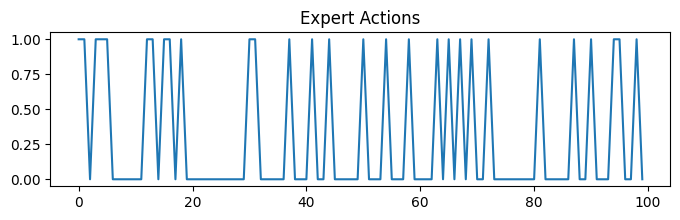

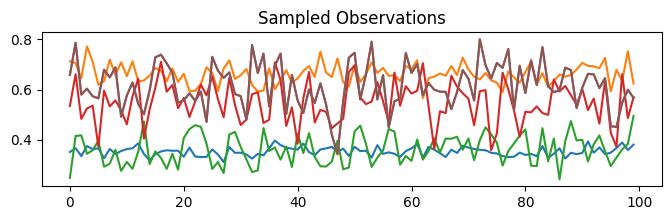

In [13]:
obsvs = []
acts = []

for n in range(len(rollouts)):
    acts.append(demonstrations.acts[n])
    obsvs.append(demonstrations.obs[n])

plt.figure(figsize=(8, 2))
plt.title('Expert Actions')
plt.plot(acts)

plt.figure(figsize=(8, 2))
plt.title('Sampled Observations')
plt.plot(obsvs)

## 3.2 Set up IRL algorithm
- Set up our behavior cloning algorithm
- Compute rewards before showing expert demonstrations

In [17]:
from imitation.algorithms import bc
from imitation.util import logger as imit_logger

if TENSOR_BOARD:
    # Set new logger
    tmp_path_irl = f'{PATH}/tensorboard/irl_log/BC/'
    new_logger_irl = imit_logger.configure(tmp_path_irl, ["stdout", "csv", "tensorboard"])

    bc_trainer = bc.BC(
        observation_space=mt_venv.observation_space,
        action_space=mt_venv.action_space,
        demonstrations=demonstrations,
        batch_size=BATCH_SIZE,
        rng=rng,
        device='cpu',
        custom_logger = new_logger_irl)
else:
    bc_trainer = bc.BC(
        observation_space=mt_venv.observation_space,
        action_space=mt_venv.action_space,
        demonstrations=demonstrations,
        batch_size=BATCH_SIZE,
        rng=rng,
        device='cpu')

In [18]:
reward_before_training, _ = evaluate_policy(bc_trainer.policy, mt_venv, EVALUATION_ROUNDS)
print(f"Reward before training: {reward_before_training: 4.3f}")

Reward before training:  271.922


## 3.3 Apply IRL - BC algo.
- Use expert demonstrations and learn the reward function - using Behavior Cloning algorithm- 
Compute reward and compares befor/aftere showing expert demonstrations

In [19]:
bc_trainer.train(n_epochs=1)

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 76.5      |
|    loss           | 0.693     |
|    neglogp        | 0.693     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 16        |
---------------------------------


491batch [00:01, 339.63batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000599 |
|    entropy        | 0.599     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 77.4      |
|    loss           | 0.506     |
|    neglogp        | 0.507     |
|    prob_true_act  | 0.634     |
|    samples_so_far | 8016      |
---------------------------------


973batch [00:02, 348.55batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -0.000608 |
|    entropy        | 0.608     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 77.2      |
|    loss           | 0.673     |
|    neglogp        | 0.674     |
|    prob_true_act  | 0.552     |
|    samples_so_far | 16016     |
---------------------------------


1492batch [00:04, 334.27batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -0.000608 |
|    entropy        | 0.608     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 77.3      |
|    loss           | 0.72      |
|    neglogp        | 0.72      |
|    prob_true_act  | 0.529     |
|    samples_so_far | 24016     |
---------------------------------


1972batch [00:05, 361.84batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 2000      |
|    ent_loss       | -0.000622 |
|    entropy        | 0.622     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 77        |
|    loss           | 0.569     |
|    neglogp        | 0.569     |
|    prob_true_act  | 0.594     |
|    samples_so_far | 32016     |
---------------------------------


2472batch [00:07, 357.34batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 2500      |
|    ent_loss       | -0.000624 |
|    entropy        | 0.624     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 76.8      |
|    loss           | 0.479     |
|    neglogp        | 0.48      |
|    prob_true_act  | 0.637     |
|    samples_so_far | 40016     |
---------------------------------


2974batch [00:08, 381.16batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 3000      |
|    ent_loss       | -0.000634 |
|    entropy        | 0.634     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 76.7      |
|    loss           | 0.618     |
|    neglogp        | 0.619     |
|    prob_true_act  | 0.565     |
|    samples_so_far | 48016     |
---------------------------------


3499batch [00:10, 361.17batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 3500      |
|    ent_loss       | -0.000599 |
|    entropy        | 0.599     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 76.9      |
|    loss           | 0.677     |
|    neglogp        | 0.678     |
|    prob_true_act  | 0.554     |
|    samples_so_far | 56016     |
---------------------------------


3982batch [00:11, 344.50batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 4000      |
|    ent_loss       | -0.000638 |
|    entropy        | 0.638     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 76.4      |
|    loss           | 0.8       |
|    neglogp        | 0.801     |
|    prob_true_act  | 0.476     |
|    samples_so_far | 64016     |
---------------------------------


4488batch [00:13, 365.12batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 4500      |
|    ent_loss       | -0.000634 |
|    entropy        | 0.634     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 76.4      |
|    loss           | 0.578     |
|    neglogp        | 0.579     |
|    prob_true_act  | 0.585     |
|    samples_so_far | 72016     |
---------------------------------


4983batch [00:14, 345.50batch/s]

--------------------------------
| batch_size        | 16       |
| bc/               |          |
|    batch          | 5000     |
|    ent_loss       | -0.00062 |
|    entropy        | 0.62     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 76.2     |
|    loss           | 0.57     |
|    neglogp        | 0.571    |
|    prob_true_act  | 0.595    |
|    samples_so_far | 80016    |
--------------------------------


5481batch [00:15, 356.16batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 5500      |
|    ent_loss       | -0.000638 |
|    entropy        | 0.638     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 75.9      |
|    loss           | 0.539     |
|    neglogp        | 0.54      |
|    prob_true_act  | 0.601     |
|    samples_so_far | 88016     |
---------------------------------


5627batch [00:16, 350.47batch/s]
5656batch [00:16, 344.77batch/s]


In [20]:
now = datetime.now()
dt_string = now.strftime("%d-%b-%Y  %H:%M:%S")
reward_after_training, _ = evaluate_policy(bc_trainer.policy, mt_venv, EVALUATION_ROUNDS)

print('-'*120)
print(' **** IRL with Imitation Libraries and Milling environment ****')
print('-'*120)

print(dt_string)
print(f'Episodes: {EPISODES}')
print(f'Expert performance:             {reward_ppo:5.3f}')
print(f'Apprentice performance: Before: {reward_before_training:5.3f}')
print(f'                        After:  {reward_after_training:5.3f}')
# print(f'Training time: {elapsed_time:5.3f} seconds')

------------------------------------------------------------------------------------------------------------------------
 **** IRL with Imitation Libraries and Milling environment ****
------------------------------------------------------------------------------------------------------------------------
15-Aug-2024  21:08:18
Episodes: 4000
Expert performance:             4176.704
Apprentice performance: Before: 271.922
                        After:  4178.979


## Results
```
-------------------------------------------------------------------------------------
| Date-time             | Episodes | Expert   | Apprentice-before |Apprentice-after |
-------------------------------------------------------------------------------------
| 07-Aug-2024  20:51:01 | 4000     | 4176.156 | 147.070           | 4180.070        |
| 07-Aug-2024  21:53:24 |  400     | 4176.033 | 536.258           | 4174.686        |
| 07-Aug-2024  21:53:24 | 4000     | 4176.033 | 536.258           | 4174.686        |
0
```

## 3.3.b Apply IRL - SQIL algo.
- Use expert demonstrations and learn the reward function - using ## 3.3 Apply IRL (BC)
- Use expert demonstrations and learn the reward function - using Behavior Cloning algorithm
- Compute rewards and compare before/after showing expert demonstrations algorithm
- Compute rewards and compare before/after showing expert demonstrations

In [26]:
import tempfile
from imitation.algorithms.dagger import SimpleDAggerTrainer, DAggerTrainer
from imitation.policies.serialize import load_policy

if TENSOR_BOARD:
    # Set new logger
    tmp_path_irl = f'{PATH}/tensorboard/irl_log/DG/'
    new_logger_irl = imit_logger.configure(tmp_path_irl, ["stdout", "csv", "tensorboard"])

    with tempfile.TemporaryDirectory(prefix="dagger_example_") as tmpdir:
        print(tmpdir)
        dagger_trainer = SimpleDAggerTrainer(
            venv = mt_venv,
            scratch_dir = tmpdir,
            expert_policy = expert_ppo,
            bc_trainer = bc_trainer,
            rng=rng,
            custom_logger = new_logger_irl,
        )        
else:
    with tempfile.TemporaryDirectory(prefix="dagger_example_") as tmpdir:
        print(tmpdir)
        dagger_trainer = SimpleDAggerTrainer(
            venv = mt_venv,
            scratch_dir = tmpdir,
            expert_policy = expert_ppo,
            bc_trainer = bc_trainer,
            rng=rng,
        )

dagger_trainer.train(EPISODES)

C:\Users\Rajesh\AppData\Local\Temp\dagger_example_swyi9yt_


Saving the dataset (1/1 shards): 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 195.49 examples/s]
0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000608 |
|    entropy        | 0.608     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 76.1      |
|    loss           | 0.352     |
|    neglogp        | 0.353     |
|    prob_true_act  | 0.703     |
|    samples_so_far | 16        |
| rollout/          |           |
|    return_max     | 2.95e+03  |
|    return_mean    | 2.89e+03  |
|    return_min     | 2.81e+03  |
|    return_std     | 46.8      |
---------------------------------


127batch [00:20, 12.99batch/s]
324batch [00:21, 83.06batch/s]
469batch [00:21, 195.08batch/s][A
469batch [00:31, 195.08batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -4.54e-06 |
|    entropy        | 0.00454   |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 84.6      |
|    loss           | 0.000528  |
|    neglogp        | 0.000533  |
|    prob_true_act  | 0.999     |
|    samples_so_far | 8016      |
| rollout/          |           |
|    return_max     | 4.19e+03  |
|    return_mean    | 4.17e+03  |
|    return_min     | 4.15e+03  |
|    return_std     | 12.5      |
---------------------------------


646batch [00:41, 23.79batch/s] 
664batch [00:41, 16.06batch/s]
Saving the dataset (1/1 shards): 100%|████████████████████████████████████████████████████| 1/1 [00:00<?, ? examples/s]
0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -3.42e-06 |
|    entropy        | 0.00342   |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 84.9      |
|    loss           | 0.000383  |
|    neglogp        | 0.000386  |
|    prob_true_act  | 1         |
|    samples_so_far | 16        |
| rollout/          |           |
|    return_max     | 4.19e+03  |
|    return_mean    | 4.18e+03  |
|    return_min     | 4.16e+03  |
|    return_std     | 12.9      |
---------------------------------


309batch [00:20, 85.52batch/s]
468batch [00:34, 204.00batch/s][A

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -1.83e-06 |
|    entropy        | 0.00183   |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 85.6      |
|    loss           | 0.00019   |
|    neglogp        | 0.000192  |
|    prob_true_act  | 1         |
|    samples_so_far | 8016      |
| rollout/          |           |
|    return_max     | 4.19e+03  |
|    return_mean    | 4.17e+03  |
|    return_min     | 4.15e+03  |
|    return_std     | 12.5      |
---------------------------------


663batch [00:40, 26.79batch/s] 
997batch [00:41, 233.72batch/s][A
997batch [00:54, 233.72batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -1.17e-06 |
|    entropy        | 0.00117   |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 86.2      |
|    loss           | 0.000115  |
|    neglogp        | 0.000116  |
|    prob_true_act  | 1         |
|    samples_so_far | 16016     |
| rollout/          |           |
|    return_max     | 4.19e+03  |
|    return_mean    | 4.17e+03  |
|    return_min     | 4.15e+03  |
|    return_std     | 13.7      |
---------------------------------


1322batch [01:01, 93.00batch/s]
1332batch [01:01, 21.82batch/s]


In [29]:
# import tempfile
# from imitation.algorithms.dagger import SimpleDAggerTrainer, DAggerTrainer
# from imitation.policies.serialize import load_policy

# if TENSOR_BOARD:
#     # Set new logger
#     tmp_path_irl = f'{PATH}/tensorboard/irl_log/DG/'
#     new_logger_irl = imit_logger.configure(tmp_path_irl, ["stdout", "csv", "tensorboard"])

#     with tempfile.TemporaryDirectory(prefix="dagger_example_") as tmpdir:
#         print(tmpdir)
#         dagger_trainer = DAggerTrainer(
#             venv = mt_venv,
#             scratch_dir = tmpdir,
#             # expert_policy = expert_ppo,
#             bc_trainer = bc_trainer,
#             rng=rng,
#             custom_logger = new_logger_irl,
#         )        
# else:
#     with tempfile.TemporaryDirectory(prefix="dagger_example_") as tmpdir:
#         print(tmpdir)
#         dagger_trainer = DAggerTrainer(
#             venv = mt_venv,
#             scratch_dir = tmpdir,
#             # expert_policy = expert_ppo,
#             bc_trainer = bc_trainer,
#             rng=rng,
#         )

# dagger_trainer.train(EPISODES)

In [27]:
reward_DG, _ = evaluate_policy(dagger_trainer.policy, mt_venv, EVALUATION_ROUNDS)
print("Reward:", reward_DG)

Reward: 4171.91363635


In [28]:
print(f'Episodes: {EPISODES}')
print('')
print(f'Expert performance:              {reward_ppo:5.3f}')
print(f'Apprentice performance:          {reward_before_training:5.3f}')
print(f'Apprentice performance - BCO:    {reward_after_training:5.3f}')
print(f'Apprentice performance - DAgger: {reward_DG:5.3f}')
# print(f'Training time: {elapsed_time:5.3f} seconds')

Episodes: 4000

Expert performance:              4176.704
Apprentice performance:          271.922
Apprentice performance - BCO:    4178.979
Apprentice performance - DAgger: 4171.914
